# Collaboration and Competition

---

You are welcome to use this coding environment to train your agent for the project.  Follow the instructions below to get started!

### 1. Start the Environment

Run the next code cell to install a few packages.  This line will take a few minutes to run!

In [5]:
!pip -q install ./python

The environment is already saved in the Workspace and can be accessed at the file path provided below. 

Environments contain **_brains_** which are responsible for deciding the actions of their associated agents. Here we check for the first brain available, and set it as the default brain we will be controlling from Python.

In [6]:
from unityagents import UnityEnvironment
import numpy as np

env = UnityEnvironment(file_name="/data/Tennis_Linux_NoVis/Tennis")

INFO:unityagents:
'Academy' started successfully!
Unity Academy name: Academy
        Number of Brains: 1
        Number of External Brains : 1
        Lesson number : 0
        Reset Parameters :
		
Unity brain name: TennisBrain
        Number of Visual Observations (per agent): 0
        Vector Observation space type: continuous
        Vector Observation space size (per agent): 8
        Number of stacked Vector Observation: 3
        Vector Action space type: continuous
        Vector Action space size (per agent): 2
        Vector Action descriptions: , 


In [7]:
# get the default brain
brain_name = env.brain_names[0]
brain = env.brains[brain_name]

### 2. Examine the State and Action Spaces

Run the code cell below to print some information about the environment.

In [8]:
# reset the environment
env_info = env.reset(train_mode=True)[brain_name]

# number of agents 
num_agents = len(env_info.agents)
print('Number of agents:', num_agents)

# size of each action
action_size = brain.vector_action_space_size
print('Size of each action:', action_size)

# examine the state space 
states = env_info.vector_observations
state_size = states.shape[1]
print('There are {} agents. Each observes a state with length: {}'.format(states.shape[0], state_size))
print('The state for the first agent looks like:', states[0])

Number of agents: 2
Size of each action: 2
There are 2 agents. Each observes a state with length: 24
The state for the first agent looks like: [ 0.          0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.          0.
  0.          0.         -6.65278625 -1.5        -0.          0.
  6.83172083  6.         -0.          0.        ]


### 3. Take Random Actions in the Environment

In the next code cell, you will learn how to use the Python API to control the agent and receive feedback from the environment.

Note that **in this coding environment, you will not be able to watch the agents while they are training**, and you should set `train_mode=True` to restart the environment.

In [9]:
for i in range(5):                                         # play game for 5 episodes
    env_info = env.reset(train_mode=False)[brain_name]     # reset the environment    
    states = env_info.vector_observations                  # get the current state (for each agent)
    scores = np.zeros(num_agents)                          # initialize the score (for each agent)
    while True:
        actions = np.random.randn(num_agents, action_size) # select an action (for each agent)
        actions = np.clip(actions, -1, 1)                  # all actions between -1 and 1
        env_info = env.step(actions)[brain_name]           # send all actions to tne environment
        next_states = env_info.vector_observations         # get next state (for each agent)
        rewards = env_info.rewards                         # get reward (for each agent)
        dones = env_info.local_done                        # see if episode finished
        scores += env_info.rewards                         # update the score (for each agent)
        states = next_states                               # roll over states to next time step
        if np.any(dones):                                  # exit loop if episode finished
            break
    print('Total score (averaged over agents) this episode: {}'.format(np.mean(scores)))

Total score (averaged over agents) this episode: -0.004999999888241291
Total score (averaged over agents) this episode: 0.04500000085681677
Total score (averaged over agents) this episode: -0.004999999888241291
Total score (averaged over agents) this episode: -0.004999999888241291
Total score (averaged over agents) this episode: -0.004999999888241291


When finished, you can close the environment.

In [6]:
#env.close()

### 4. It's Your Turn!

Now it's your turn to train your own agent to solve the environment!  A few **important notes**:
- When training the environment, set `train_mode=True`, so that the line for resetting the environment looks like the following:
```python
env_info = env.reset(train_mode=True)[brain_name]
```
- To structure your work, you're welcome to work directly in this Jupyter notebook, or you might like to start over with a new file!  You can see the list of files in the workspace by clicking on **_Jupyter_** in the top left corner of the notebook.
- In this coding environment, you will not be able to watch the agents while they are training.  However, **_after training the agents_**, you can download the saved model weights to watch the agents on your own machine! 

In [10]:

import random 
import torch 

import requests
import time

import matplotlib.pyplot as plt
%matplotlib inline

from maddpg_agent import Agent, OUNoise
from unityagents import UnityEnvironment 
from collections import deque


# a helper to plot a training scores
def plot_scores( n_episode ,scores, 
                color = 'b', 
                title = '', 
                linestyle = '-',
                xlabel='Episode',
                ylabel='Score',
                fig = None, 
                axes = None, 
                showRequirement = True ) :
    # iteration indices (recall, smoothed start at step 100)
    x = range(1, n_episode+1) #scores[0]
    y = scores
    
    if fig is None or axes is None :
        fig, axes = plt.subplots()
    
    axes.grid( True )
    axes.plot( x, y, color = color, linestyle = linestyle )
    axes.set_title( title )
    
    # if scores plot, then plot the requirement
    if showRequirement :
        axes.axhline( 30., linestyle = '--' )
    
    axes.set_xlabel( xlabel )
    axes.set_ylabel( ylabel )
    
    return fig, axes

In [11]:

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# DDPG function 
def maddpg(agent, n_episodes=1000, max_t=300, print_every=100, required_episode=110):
    scores_all = []
    scores_local = deque(maxlen=100)
    moving_average_scores = []
    
    old_time = time.time()
    response = requests.request("GET", 
                            "http://metadata.google.internal/computeMetadata/v1/instance/attributes/keep_alive_token", 
                            headers={"Metadata-Flavor":"Google"})
    solved_at = -1 
    for i_episode in range(1, n_episodes+1):
        
        if time.time() - old_time > 60:
            old_time = time.time()
            requests.request("POST", 
                             "https://nebula.udacity.com/api/v1/remote/keep-alive", 
                             headers={'Authorization': "STAR " + response.text})
            
        env_info = env.reset(train_mode=True)[brain_name] # reset environment 
        states = env_info.vector_observations   
        agent.reset()
        scores = np.zeros(num_agents)  
        start_time = time.time()
        for t in range(max_t):
            action_0 = agent.act(states[0])
            action_1 = agent.act(states[1])
            actions = np.concatenate((action_0, action_1), axis=0)
            actions = np.clip(actions, -1, 1)
            env_info = env.step(actions)[brain_name]
            next_states = env_info.vector_observations 
            rewards = env_info.rewards
            dones = env_info.local_done
            agent.step(states, actions, rewards, next_states, dones)
            
            states = next_states
            scores += rewards
            if np.any(env_info.local_done):
                break
            
            #agent.step(state, action, reward, next_state, done)
            #state = next_state
            #score += reward
            #if done:
            #    break 
        time_cost = time.time() - start_time
        best_score = np.max(scores) 
        
        scores_all.append(best_score)
        scores_local.append(best_score)
        moving_average_scores.append(np.mean(scores_local))
        
        if i_episode % print_every == 0:   
            print('\n\rEpisode {} \tcost {:.4f}(S) \tCurrent Score: {:.4f} \tAverage Score: {:.4f}'.format(i_episode, (time_cost), scores_all[-1], moving_average_scores[-1]), end="")
            torch.save(agent.actor_local.state_dict(), 'checkpoint_actor.pth')
            torch.save(agent.critic_local.state_dict(), 'checkpoint_critic.pth')
            if moving_average_scores[-1] > 0.5:
                if solved_at < 0:
                    print('\n\rEnvironment solved in {} episodes with Average Score: {:.2f}'.format(i_episode, moving_average_scores[-1]))
                    solved_at = i_episode
        if i_episode >= required_episode:
            if solved_at > 0:
                print('\n\rFinish {} episodes the problem has been solved at {} episode '.format(required_episode ,solved_at))
                break
            # else:
                # print('\n\rFinish {} episodes the problem has not been solved !'.format(required_episode))
    return scores_all, moving_average_scores


Episode 100 	cost 0.2088(S) 	Current Score: 0.0000 	Average Score: 0.0000
Episode 200 	cost 0.7359(S) 	Current Score: 0.1000 	Average Score: 0.0028
Episode 300 	cost 0.2097(S) 	Current Score: 0.0000 	Average Score: 0.0000
Episode 400 	cost 0.2219(S) 	Current Score: 0.0000 	Average Score: 0.0137
Episode 500 	cost 0.2174(S) 	Current Score: 0.0000 	Average Score: 0.0020
Episode 600 	cost 0.2147(S) 	Current Score: 0.0000 	Average Score: 0.0000
Episode 700 	cost 0.2105(S) 	Current Score: 0.0000 	Average Score: 0.0010
Episode 800 	cost 0.4615(S) 	Current Score: 0.1000 	Average Score: 0.0280
Episode 900 	cost 0.4635(S) 	Current Score: 0.0900 	Average Score: 0.0992
Episode 1000 	cost 0.4499(S) 	Current Score: 0.0900 	Average Score: 0.0946
Episode 1100 	cost 0.4956(S) 	Current Score: 0.1000 	Average Score: 0.2210
Episode 1200 	cost 1.1264(S) 	Current Score: 0.2000 	Average Score: 0.0697
Episode 1300 	cost 15.3481(S) 	Current Score: 2.6000 	Average Score: 1.1126
Environment solved in 1300 episo

(<matplotlib.figure.Figure at 0x7fafdaee05c0>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7fafdaecf198>)

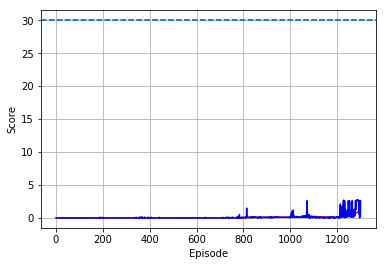

In [12]:

# Instantiate a Multi Agent
agent = Agent(state_size=state_size, action_size=action_size, num_agents=num_agents, random_seed=3)

all_scores, local_mean_scores = maddpg(agent, n_episodes=2400, max_t=1000, required_episode=1000)
fig, axes = plot_scores(n_episode=len(local_mean_scores), scores=local_mean_scores, color='r')
plot_scores(n_episode=len(all_scores), scores=all_scores, color='b', fig=fig, axes=axes)

In [ ]:
agent = Agent(state_size=state_size, action_size=action_size, num_agents=num_agents, random_seed=7)

agent.actor_local.load_state_dict(torch.load('checkpoint_actor.pth'))
agent.critic_local.load_state_dict(torch.load('checkpoint_critic.pth'))
env_info = env.reset(train_mode=False)[brain_name]
states = env_info.vector_observations
scores = np.zeros(num_agents)

while True:
    action_0 = agent.act(states[0])
    action_1 = agent.act(states[1])
    actions = np.concatenate((action_0, action_1), axis=0)
    actions = np.clip(action, -1, 1)
    env_info = env.step(actions)[brain_name]
    next_states = env_info.vector_observations 
    rewards = env_info.rewards 
    dones = env_info.local_done
    scores += rewards 
    states = next_states 
    if np.any(dones):
        break

print('avering scores: {}'.format(np.mean(scores)))

    

In [ ]:
env.close()